### Import statements

In [129]:
import warnings

warnings.filterwarnings("ignore")

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Loading the customer churn dataset

In [131]:
churn = pd.read_csv("./datasets/churn.csv")

In [132]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_churned                400 non-null    int64  
 1   time_since_first_purchase  400 non-null    float64
 2   time_since_last_purchase   400 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


In [133]:
churn.head()

,has_churned,time_since_first_purchase,time_since_last_purchase
0,0,-1.089221,-0.721322
1,0,1.182983,3.634435
2,0,-0.846156,-0.427582
3,0,0.086942,-0.535672
4,0,-1.166642,-0.672640


This dataset on churn is from a European financial services company in 2006. There are 400 rows, each representing a customer. If the customer closed all accounts during the time period (i.e, in 2006), they were considered to have churned, and the "has_churned" column is marked with a one. If they still had an open account at the end of the time period, "has_churned" is marked with a zero. The two explanatory variables are the time since the customer first bought a service and the time since they last bought a service. Respectively, they measure the length of the relationship with the customer and the recency of the customer's activity. The time columns contain negative values because they have been standardized for confidentiality reasons. 

## Simple logistic regression modeling

A linear regression model is used when both the response variable and the explanatory variable are numerical. Often they are also continuous. 

But when the explanatory variables are numerical and the response variable is binary ($y$ is either 0 or 1) i.e, the response variable represents success or failure of an event, we will likely want our model to predict the probability of success. In this case, linear models are not appropriate. 

There are several reasons as to why. First, the linear model can predict values outside the range of 0 and 1. Second, instead of capturing the true relationship between the explanatory and response variables, the linear model goes through the middle of the data (since all the data points are either 0 or 1). 

This is demonstrated in the example below where we fit a linear model to the churn data.

In [134]:
mdl_churn_vs_recency_lin = smf.ols(
    "has_churned ~ time_since_last_purchase", data=churn
).fit()

In [135]:
mdl_churn_vs_recency_lin.params

Intercept                   0.490780
time_since_last_purchase    0.063783
dtype: float64

In [136]:
intercept, slope = mdl_churn_vs_recency_lin.params

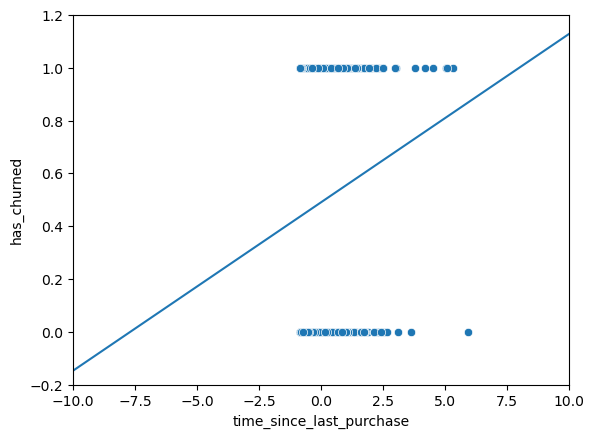

In [137]:
# scatterplot
ax = sns.scatterplot(data=churn, x="time_since_last_purchase", y="has_churned")

# axline is used rather than sns dot regplot so the line isn't limited to the extent of the data
ax.axline(xy1=(0, intercept), slope=slope)

ax.set(xlim=(-10, 10), ylim=(-0.2, 1.2))

plt.show()

All the churn values are zero or one, but the model predictions are fractional. You can think of the predictions as being probabilities that the customer will churn. But the main problem is that the predictions are not constrained to be between zero and one. The plot above shows that the predictions are negative for some customers and exceeds one for some others.

In cases such as this we use a **logistic regression** model. The logistic regression model is a generalized linear model that uses the logistic function to model a binary response variable.

Logistic regression is a statistical model that can be used to predict the probability of a binary outcome. It is a popular machine learning algorithm that is used in a variety of applications, such as spam filtering, fraud detection, and medical diagnosis.

Logistic regression works by fitting a logistic function to the data. The logistic function is a sigmoid function that takes a real number as input and outputs a probability value between 0 and 1.

The logistic function is "S" shaped whereas the linear function is a straight line.

> To create a logistic regression model we use the `statsmodels.formula.api.logit` function. The syntax is similar to that of the `ols` function. The response variable is specified on the left side of the `~` symbol and the explanatory variables are specified on the right side. The `data` argument is used to specify the data frame that contains the variables. To fit/train the model we use the `fit` method.

In [138]:
mdl_churn_vs_recency_logit = smf.logit(
    "has_churned ~ time_since_last_purchase", data=churn
).fit()

Optimization terminated successfully.
         Current function value: 0.683000
         Iterations 4


In [139]:
mdl_churn_vs_recency_lin.params

Intercept                   0.490780
time_since_last_purchase    0.063783
dtype: float64

The model parameters has different meaning than the linear regression model parameters even though the coefficient values are the same.

To visualize the logistic regression model we can use the `sns.regplot()` function with `logistic=True`.

In [140]:
prediction_data = pd.DataFrame({"time_since_last_purchase": np.arange(-20, 21)})

In [141]:
prediction_data = prediction_data.assign(
    has_churned=mdl_churn_vs_recency_logit.predict(
        prediction_data.time_since_last_purchase
    )
)

In [142]:
prediction_data.head(2)

,time_since_last_purchase,has_churned
0,-20,0.004411
1,-19,0.005765


In [143]:
prediction_data.tail(2)

,time_since_last_purchase,has_churned
39,19,0.993819
40,20,0.995271


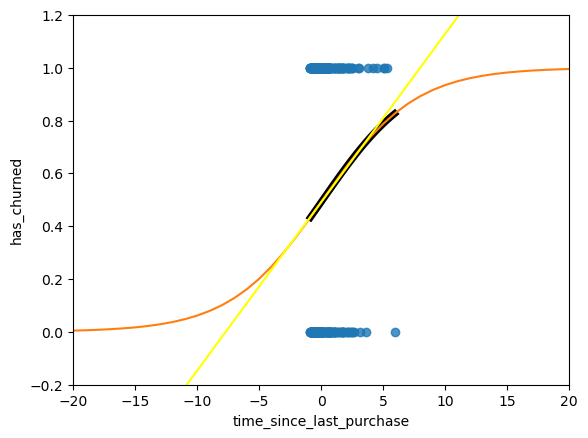

In [144]:
ax = sns.regplot(
    data=churn,
    x="time_since_last_purchase",
    y="has_churned",
    ci=None,
    logistic=True,
    line_kws=({"color": "black", "linewidth": 5}),
)
# full length sigmoid function overlaid on the regplot
sns.lineplot(x="time_since_last_purchase", y="has_churned", data=prediction_data, ax=ax)
# linear regression line overlaid on the regplot
ax.axline(xy1=(0, intercept), slope=slope, color="yellow")

ax.set(xlim=(-20, 20), ylim=(-0.2, 1.2))
plt.show()

The logistic regression curve never goes below zero or above one. To interpret this curve, when the standardized time since last purchase is very small, the probability of churning is close to zero. When the time since last purchase is very high, the probability is close to one. That is, customers who recently bought things are less likely to churn. 

### Different formats of representing the logistic regression prediction

#### -> Expressing the prediction as a probability

We've already seen this in the previous sections.

<Axes: xlabel='time_since_last_purchase', ylabel='has_churned'>

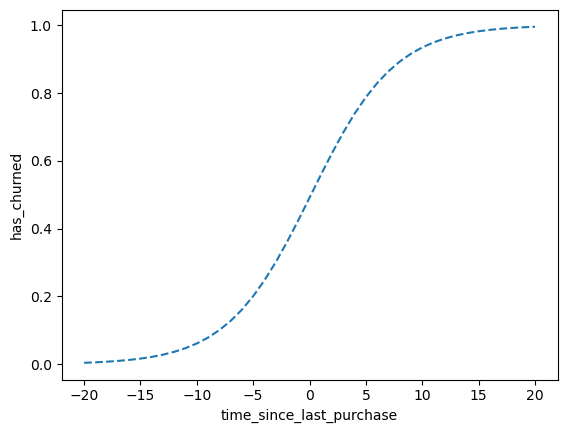

In [145]:
sns.lineplot(
    data=prediction_data, x="time_since_last_purchase", y="has_churned", linestyle="--"
)

#### -> Expressing the prediction as most likely outcome

This is nothing but rounding the probability to the nearest integer.

In [146]:
prediction_data["has_churned_rounded"] = np.round(prediction_data["has_churned"])

<Axes: xlabel='time_since_last_purchase', ylabel='has_churned_rounded'>

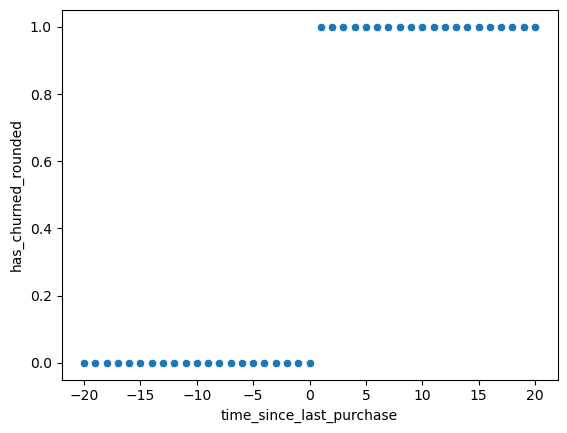

In [147]:
sns.scatterplot(
    data=prediction_data, x="time_since_last_purchase", y="has_churned_rounded"
)

#### -> Odds ratio

There is another way to talk about binary responses, commonly used in gambling. 

The odds ratio is the probability that something happens, divided by the probability that it doesn't. 

$$ Odds\ ratio  = \frac{probability\ of \ success}{1 - probability\ of\ success}$$

For example, a probability of 0.25 is the same as the odds of "three to one against", because the probability of the event not happening is 0.75, which is three times as much.

In [148]:
prediction_data["odds_ratio"] = prediction_data["has_churned"] / (1 - prediction_data["has_churned"])

[(-5.0, 10.0), (0.0, 15.0)]

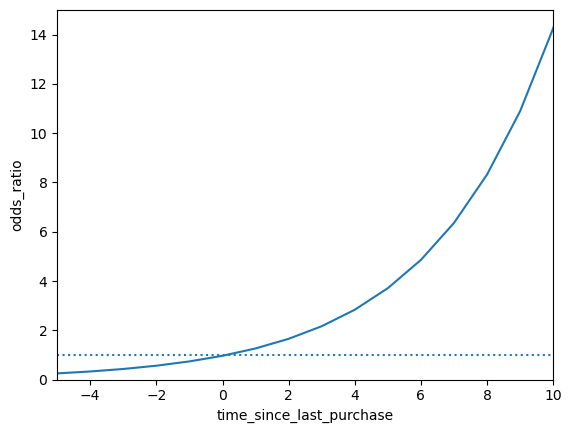

In [154]:
ax = sns.lineplot(data=prediction_data, x="time_since_last_purchase", y="odds_ratio")
ax.axhline(y=1, linestyle=":")
ax.set(xlim=(-5, 10), ylim=(0, 15))
plt.show()

Here, the dotted line (where the odds ratio = 1) indicates where churning is just as likely as not churning (as, odds ratio = probability of success / probability of failure). Ironically here, success is churning, and failure is not churning.

In the bottom-left, the predictions are below one, so the chance of churning is less than the chance of not churning. In the top-right, the chance of churning is about 15 times more than the chance of not churning.